# Data Manipulaiton

In [1]:
import os
import random
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from glob import glob
from scipy.ndimage import rotate, zoom, gaussian_filter, map_coordinates
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import (
    Conv3D, Conv3DTranspose, BatchNormalization, Activation, 
    Add, Multiply, UpSampling3D, MaxPooling3D, Input, 
    Concatenate, Dropout, SpatialDropout3D
)



## Data Preprocessing Functions

In [2]:
def hu_windowing(image, min_hu=-1000, max_hu=400):
    """
    Apply HU windowing to limit values between min_hu and max_hu.
    """
    return np.clip(image, min_hu, max_hu)

def gaussian_smoothing(image, sigma=1.0):
    """
    Apply Gaussian smoothing to reduce noise in the image.
    """
    return gaussian_filter(image, sigma=sigma)

def normalize(image):
    """
    Normalize intensity values using Z-score normalization.
    Args:
        image (numpy array): The input 3D CT image.
    Returns:
        numpy array: Normalized image.
    """
    mean = np.mean(image)
    std = np.std(image)
    
    # Avoid division by zero
    if std == 0:
        standardized_image = np.zeros_like(image)  # If all values are the same, return zeros
    else:
        standardized_image = (image - mean) / std  # Standardization

    # Normalize to the 0-1 range
    wmin = np.min(standardized_image)
    wmax = np.max(standardized_image)
    if wmax - wmin == 0:  # Avoid division by zero during normalization
        normalized_image = np.zeros_like(standardized_image)  # Default to zeros
    else:
        normalized_image = (standardized_image - wmin) / (wmax - wmin)
    
    return normalized_image


In [3]:
def preprocess(image, min_hu=-1000, max_hu=400, sigma=1.0):
    image = hu_windowing(image, min_hu=-min_hu, max_hu=max_hu)
    image = normalize(image)
    image = gaussian_smoothing(image, sigma=sigma)
    return image

## Data Augmentation Functions

In [4]:
def elastic_deformation(image, mask, alpha=1, sigma=5):
    """
    Apply elastic deformation to a 3D image and mask.

    Args:
        image (numpy array): The input 3D image.
        mask (numpy array): The corresponding mask.
        alpha (float): Scaling factor for the displacement field.
        sigma (float): Standard deviation for Gaussian smoothing of the displacement field.

    Returns:
        tuple: Deformed image and mask.
    """
    shape = image.shape

    # Generate random displacement fields
    dx = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    # Create meshgrid for indexing
    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing="ij")
    indices = (
        np.reshape(x + dx, (-1,)),
        np.reshape(y + dy, (-1,)),
        np.reshape(z + dz, (-1,))
    )

    # Apply deformation
    deformed_image = map_coordinates(image, indices, order=1, mode="reflect").reshape(shape)
    deformed_mask = map_coordinates(mask, indices, order=0, mode="reflect").reshape(shape)
    return deformed_image, deformed_mask

def random_rotation(image, mask, angle_range=(-15, 15), axes=(0, 1)):
    """
    Apply random rotation to a 3D image and mask along specified axes.

    Args:
        image (numpy array): The input 3D image.
        mask (numpy array): The corresponding mask.
        angle_range (tuple): Range of angles for rotation (in degrees).
        axes (tuple): Axes along which to rotate the image and mask.

    Returns:
        tuple: Rotated image and mask.
    """
    angle = random.uniform(*angle_range)  # Random angle in the specified range
    rotated_image = rotate(image, angle, axes=axes, reshape=False, order=1, mode="reflect")
    rotated_mask = rotate(mask, angle, axes=axes, reshape=False, order=0, mode="reflect")
    return rotated_image, rotated_mask

def random_flip(image, mask):
    """
    Apply random flipping along the z-axis (slice axis) to a 3D image and mask.

    Args:
        image (numpy array): The input 3D image.
        mask (numpy array): The corresponding mask.

    Returns:
        tuple: Flipped image and mask.
    """
    if random.random() > 0.5:  # 50% chance to flip along the z-axis
        image = np.flip(image, axis=2)
        mask = np.flip(mask, axis=2)
    return image, mask



def random_scaling(image, mask, scale_range=(0.9, 1.1), target_shape=(64, 64, 64)):
    """
    Apply random scaling to a 3D image and mask and resize back to the target shape.

    Args:
        image (numpy array): The input 3D image.
        mask (numpy array): The corresponding mask.
        scale_range (tuple): Range of scaling factors (e.g., 0.9 to 1.1).
        target_shape (tuple): The target shape to resize back to.

    Returns:
        tuple: Scaled image and mask, resized to the target shape.
    """
    scale = random.uniform(*scale_range)

    # Scale the image and mask
    scaled_image = zoom(image, (scale, scale, scale), order=1, mode="reflect")
    scaled_mask = zoom(mask, (scale, scale, scale), order=0, mode="reflect")

    # Resize back to the target shape using scipy's zoom
    scale_factors_image = [t / s for t, s in zip(target_shape, scaled_image.shape)]
    scale_factors_mask = [t / s for t, s in zip(target_shape, scaled_mask.shape)]
    resized_image = zoom(scaled_image, scale_factors_image, order=1, mode="reflect")
    resized_mask = zoom(scaled_mask, scale_factors_mask, order=0, mode="reflect")

    return resized_image, resized_mask



def random_noise(image, noise_std=0.005):
    """
    Add random Gaussian noise to a 3D image.

    Args:
        image (numpy array): The input 3D image.
        noise_std (float): Standard deviation of the Gaussian noise.

    Returns:
        numpy array: Image with added noise.
    """
    noise = np.random.normal(0, noise_std, image.shape)
    noisy_image = image + noise
    return noisy_image

def intensity_shift(image, shift_range=(-0.05, 0.05)):
    """
    Apply random intensity shift to a 3D image.
    Args:
        image (numpy array): The input 3D image.
        shift_range (tuple): Range of intensity shifts (e.g., -0.1 to 0.1).
    Returns:
        numpy array: Intensity-shifted image.
    """
    shift = random.uniform(*shift_range)
    return image + shift

def brightness_change(image, factor_range=(0.9, 1.1)):
    """
    Apply random brightness change to a 3D image.

    Args:
        image (numpy array): The input 3D image.
        factor_range (tuple): Range of brightness factors (e.g., 0.8 to 1.2).

    Returns:
        numpy array: Brightness-adjusted image.
    """
    factor = random.uniform(*factor_range)
    return image * factor

def random_contrast_stretching(image, low_percentile=1, high_percentile=99):
    """
    Apply random contrast stretching to a 3D CT image.
    Args:
        image (numpy array): Input 3D CT image.
        low_percentile (int): Lower percentile for stretching. Defaults to 2.
        high_percentile (int): Upper percentile for stretching. Defaults to 98.
    Returns:
        numpy array: Contrast-stretched image.
    """
    # Get the low and high intensity percentiles
    low, high = np.percentile(image, [low_percentile, high_percentile])
    stretched_image = np.clip((image - low) / (high - low), 0, 1)  # Map to [0, 1]
    return stretched_image


In [5]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

cases = glob("/kaggle/input/dataset-lung-seg/data/lctsc/*")  # Adjust your dataset path
ct_name = "ct.nii"
mask_name = "lung.nii"

In [6]:
# first element of the cases array
i = 0
path_to_img = os.path.join(cases[i],ct_name)

# Load the NIfTI image
img = nib.load(path_to_img)

# Get the image data as a NumPy array
data = img.get_fdata()

# Print some information about the image
print(f"Shape: {data.shape}")
print(f"Data type: {data.dtype}")
print(f"Voxel size: {img.header.get_zooms()[:3]}")

Shape: (64, 64, 64)
Data type: float64
Voxel size: (5.0, 5.0, 5.0)


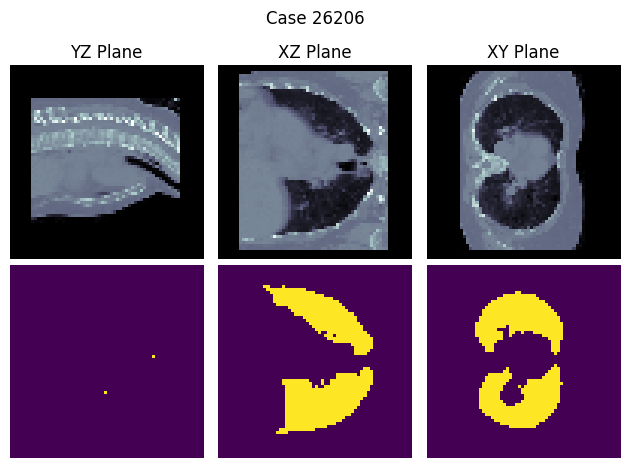

In [7]:

path_to_mask = os.path.join(cases[i],mask_name)

# Load the NIfTI image
mask = nib.load(path_to_mask)

# Get the image data as a NumPy array
data_m = mask.get_fdata()

fig, ax = plt.subplots(2,3,tight_layout=True)

fig.suptitle("Case {}".format(cases[i].split("/")[-1]))

x_dim = data.shape[0]
y_dim = data.shape[1]
z_dim = data.shape[2]

ax[0,0].set_title("YZ Plane")
ax[0,0].imshow(data[x_dim//2], cmap="bone",vmin=-1000, vmax=1000)
ax[0,0].axis("off")

ax[0,1].set_title("XZ Plane")
ax[0,1].imshow(data[:,y_dim//2], cmap="bone",vmin=-1000, vmax=1000)
ax[0,1].axis("off")

ax[0,2].set_title("XY Plane")
ax[0,2].imshow(data[...,z_dim//2], cmap="bone",vmin=-1000, vmax=1000)
ax[0,2].axis("off")

ax[1,0].imshow(data_m[x_dim//2])
ax[1,0].axis("off")
 
ax[1,1].imshow(data_m[:,y_dim//2])
ax[1,1].axis("off")

ax[1,2].imshow(data_m[...,z_dim//2])
ax[1,2].axis("off")

plt.show()
plt.close()

In [8]:
def apply_augment(image, mask):
    """
    Apply a series of random augmentations to a 3D image and mask.
    Args:
        image (numpy array): The input 3D image.
        mask (numpy array): The corresponding mask.
    Returns:
        tuple: Augmented image and mask.
    """

    image, mask = elastic_deformation(image, mask, alpha=1, sigma=5)
    image, mask = random_rotation(image, mask, angle_range=(-15, 15), axes=(0, 1))
    image, mask = random_flip(image, mask)
    image, mask = random_scaling(image, mask, scale_range=(0.9, 1.1))
    image = random_noise(image, noise_std=0.01)
    image = intensity_shift(image, shift_range=(-0.1, 0.1))
    image = brightness_change(image, factor_range=(0.9, 1.1))
    return image, mask

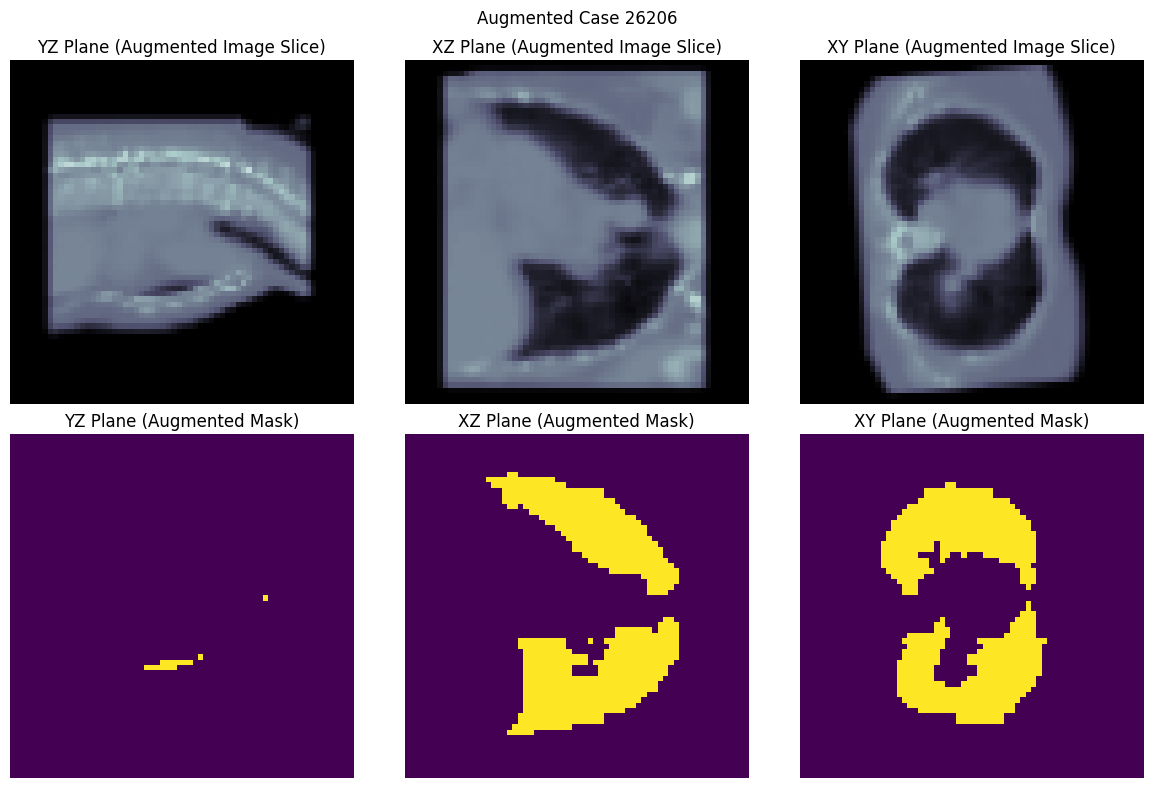

In [9]:
augmented_data, augmented_mask = apply_augment(data, data_m)

fig, ax = plt.subplots(2, 3, tight_layout=True, figsize=(12, 8))

fig.suptitle("Augmented Case {}".format(cases[i].split("/")[-1]))

x_dim = data.shape[0]
y_dim = data.shape[1]
z_dim = data.shape[2]

# Augmented  data visualization
ax[0, 0].set_title("YZ Plane (Augmented Image Slice)")
ax[0, 0].imshow(augmented_data[x_dim // 2] , cmap="bone", vmin=-1000, vmax=1000)
ax[0, 0].axis("off")

ax[0, 1].set_title("XZ Plane (Augmented Image Slice)")
ax[0, 1].imshow(augmented_data[:, y_dim // 2] , cmap="bone", vmin=-1000, vmax=1000)
ax[0, 1].axis("off")

ax[0, 2].set_title("XY Plane (Augmented Image Slice)")
ax[0, 2].imshow(augmented_data[..., z_dim // 2], cmap="bone", vmin=-1000, vmax=1000)
ax[0, 2].axis("off")

# Augmented mask visualization
ax[1, 0].set_title("YZ Plane (Augmented Mask)")
ax[1, 0].imshow(augmented_mask[x_dim // 2])
ax[1, 0].axis("off")

ax[1, 1].set_title("XZ Plane (Augmented Mask)")
ax[1, 1].imshow(augmented_mask[:, y_dim // 2])
ax[1, 1].axis("off")

ax[1, 2].set_title("XY Plane (Augmented Mask)")
ax[1, 2].imshow(augmented_mask[..., z_dim // 2])
ax[1, 2].axis("off")

plt.show()

In [93]:

def tf_augment(image, mask, target_shape=(64, 64, 64)):
    def augment_wrapper(image, mask):
        # Convert tensors to numpy arrays
        image = image.numpy()
        mask = mask.numpy()

        # Apply augmentations
        if np.random.rand() > 0.5:
            image, mask = elastic_deformation(image, mask, alpha=1, sigma=5)
        if np.random.rand() > 0.5:
            image, mask = random_rotation(image, mask, angle_range=(-15, 15), axes=(0, 1))
        if np.random.rand() > 0.5:
            image, mask = random_flip(image, mask)
        if np.random.rand() > 0.5:
            image, mask = random_scaling(image, mask, target_shape=target_shape)
        if np.random.rand() > 0.5:
            image = random_noise(image, noise_std=0.01)
        if np.random.rand() > 0.5:
            image = intensity_shift(image, shift_range=(-0.1, 0.1))
        if np.random.rand() > 0.5:
            image = brightness_change(image, factor_range=(0.8, 1.2))
        """if np.random.rand() > 0.5:
            image = random_contrast_stretching(image, low_percentile=2, high_percentile=98)"""

        return image, mask

    # Wrap the Python function using tf.py_function
    augmented_image, augmented_mask = tf.py_function(
        func=augment_wrapper,
        inp=[image, mask],
        Tout=[tf.float32, tf.float32]
    )

    # Ensure shapes are set for TensorFlow
    augmented_image.set_shape(target_shape)
    augmented_mask.set_shape(target_shape)

    return augmented_image, augmented_mask



In [94]:

# Split original data into training, validation, and test sets
train_cases, test_cases = train_test_split(cases,train_size=54, test_size=6, random_state=42)
train_cases, val_cases = train_test_split(train_cases,train_size=48, test_size=6, random_state=42)

# Load, preprocess, and augment datasets
def load_and_preprocess_cases(cases):
    images, masks = [], []
    for case in cases:
        image = nib.load(f"{case}/ct.nii").get_fdata()
        mask = nib.load(f"{case}/lung.nii").get_fdata()
        # Preprocess (without augmentation)
        #image, mask = preprocess_and_augment(image, mask, augment_data=False)
        preprocess(image)

        images.append(image)
        masks.append(mask)
    return images, masks

            
# Load preprocessed datasets
train_images, train_masks = load_and_preprocess_cases(train_cases)
val_images, val_masks = load_and_preprocess_cases(val_cases)
test_images, test_masks = load_and_preprocess_cases(test_cases)



In [95]:
def create_tf_dataset(data, masks, batch_size):
    buffer_size=len(data)
    dataset = tf.data.Dataset.from_tensor_slices((data, masks))
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE).batch(batch_size)
    return dataset



class DynamicAugmentationSequence(Sequence):
    def __init__(self, data, labels, batch_size, augment_fn=None):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.augment_fn = augment_fn

    def __len__(self):
        # Number of batches per epoch
        return len(self.data) // self.batch_size

    def __getitem__(self, idx):
        # Select batch data
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Create a tf.data.Dataset for the batch
        dataset = tf.data.Dataset.from_tensor_slices((batch_data, batch_labels))

        # Dynamically apply augmentations, if provided
        if self.augment_fn:
            dataset = dataset.map(self.augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
        
        # Batch and prefetch
        dataset = dataset.batch(self.batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

        # Return the batch as NumPy arrays for compatibility with Keras
        for images, labels in dataset:
            return images.numpy(), labels.numpy()



In [96]:
# Instantiate the sequence
sequence = DynamicAugmentationSequence(train_images, train_masks, batch_size=4, augment_fn=tf_augment)
val_data = create_tf_dataset(val_images, val_masks, batch_size=2)
test_data = create_tf_dataset(test_images, test_masks, batch_size=2)

# U-Net Model

In [97]:

# down
def down(previous_layer,k, **kargs):
    d = Conv3D(k,3,padding="same",**kargs)(previous_layer)
    d = BatchNormalization()(d)
    d = Activation('relu')(d)
    d = SpatialDropout3D(0.5)(d)
    d = Conv3D(k,3,padding="same",**kargs)(d)
    d = BatchNormalization()(d)
    d = Activation('relu')(d)
    d = SpatialDropout3D(0.5)(d)
    d = Conv3D(k,3,padding="same",**kargs)(d)
    d = BatchNormalization()(d)
    d = MaxPooling3D()(d)

    res = Conv3D(k,3,strides=2,padding="same",**kargs)(previous_layer)
    d = Add()([res,d])
    d = Activation('relu')(d)
    return d

# up
def up(previous_layer,down_layer,k, **kargs):
    u = Conv3DTranspose(k,3,padding="same",**kargs)(previous_layer)
    u = BatchNormalization()(u)
    u = Activation('relu')(u)
    u = Concatenate(axis=-1)([u,down_layer])
    u = Conv3D(k,3,padding="same",**kargs)(u)
    u = BatchNormalization()(u)
    u = Activation('relu')(u)
    u = Conv3D(k,3,padding="same",**kargs)(u)
    u = BatchNormalization()(u)
    u = UpSampling3D()(u)

    res = UpSampling3D()(previous_layer)
    res = Conv3D(k,1,padding="same",**kargs)(res)
    u = Add()([u,res])
    u = Activation('relu')(u)
    return u

def model(input_shape=(64,64,64,1),k1=8,reg=0.1):
    inputs=keras.layers.Input(shape=(input_shape))
    
    initializer = keras.initializers.Constant(1.)
    params = {"kernel_regularizer" : keras.regularizers.l2(reg), 
              "kernel_initializer" : 'random_normal'}
        
    d1 = down(inputs,k1)
    d2 = down(d1,k1*2)
    d3 = down(d2,k1*4)
    
    # bottleneck
    b = Conv3D(k1*8,3,padding="same",**params)(d3)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)
    b = Conv3D(k1*8,3,padding="same",**params)(b)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)
        
    u1 = up(b ,d3,k1*4)
    u2 = up(u1,d2,k1*2)
    u3 = up(u2,d1,k1)
    
    out = Conv3D(1,3,padding="same",**params)(u3)
    out = keras.activations.sigmoid(out)
    
    model=keras.models.Model(inputs=inputs,outputs=out)

    return model


keras.backend.clear_session()
unet = model()
unet.summary(line_length=150)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━
┃ Layer (type)                               ┃ Output Shape                         ┃                 Param # ┃ Con
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━
│ input_layer (InputLayer)                   │ (None, 64, 64, 64, 1)                │                       0 │ -  
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ conv3d (Conv3D)                            │ (None, 64, 64, 64, 8)                │                     224 │ inp
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ batch_normalization (BatchNormalization)   │ (None, 64, 64, 64, 8)                │                      32 │ con
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ activation (Activation)                    │ (None, 64, 64, 64, 8)                │                       0 │ bat
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ spatial_dropout3d (SpatialDropout3D)       │ (None, 64, 64, 64, 8)                │                       0 │ act
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ conv3d_1 (Conv3D)                          │ (None, 64, 64, 64, 8)                │                   1,736 │ spa
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ batch_normalization_1 (BatchNormalization) │ (None, 64, 64, 64, 8)                │                      32 │ con
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ activation_1 (Activation)                  │ (None, 64, 64, 64, 8)                │                       0 │ bat
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ spatial_dropout3d_1 (SpatialDropout3D)     │ (None, 64, 64, 64, 8)                │                       0 │ act
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ conv3d_2 (Conv3D)                          │ (None, 64, 64, 64, 8)                │                   1,736 │ spa
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ batch_normalization_2 (BatchNormalization) │ (None, 64, 64, 64, 8)                │                      32 │ con
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ conv3d_3 (Conv3D)                          │ (None, 32, 32, 32, 8)                │                     224 │ inp
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ max_pooling3d (MaxPooling3D)               │ (None, 32, 32, 32, 8)                │                       0 │ bat
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ add (Add)                                  │ (None, 32, 32, 32, 8)                │                       0 │ con
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ activation_2 (Activation)                  │ (None, 32, 32, 32, 8)                │                       0 │ add
├────────────────────────────────────────────┼──────────────────────────────────────┼─────────────────────────┼────
│ conv3d_4 (Conv3D)                          │ (None, 32, 32, 32, 16)               │                   3,472 │ act
├────────────────────────────────────────────┼──────────

 Total params: 460,233 (1.76 MB)

 Trainable params: 459,305 (1.75 MB)

 Non-trainable params: 928 (3.62 KB)

In [98]:
def Dice(targets, inputs, smooth=1e-6):
    """
    Dice coefficient metric for binary segmentation.
    Args:
        targets: Ground truth binary mask.
        inputs: Predicted binary mask.
        smooth: Smoothing factor to avoid division by zero.
    Returns:
        Dice coefficient value.
    """
    # Flatten tensors
    inputs = keras.backend.cast(keras.backend.flatten(inputs), dtype='float32')
    targets = keras.backend.cast(keras.backend.flatten(targets), dtype='float32')

    """    # Check if both targets and inputs are empty
    if keras.backend.sum(targets) == 0 and keras.backend.sum(inputs) == 0:
        return 1.0  # Return perfect Dice coefficient when both are empty"""

    # Compute intersection and Dice coefficient
    intersection = keras.backend.sum(targets * inputs)
    denominator = keras.backend.sum(targets) + keras.backend.sum(inputs) + smooth
    """    if keras.backend.equal(denominator, smooth):  # Only smoothing in the denominator
        return 0.0  # Handle edge case explicitly"""

    dice = (2 * intersection + smooth) / denominator
    return dice


def DiceLoss(targets, inputs, smooth=1e-6):
    """
    Dice loss function.
    Args:
        targets: Ground truth binary mask.
        inputs: Predicted binary mask.
        smooth: Smoothing factor to avoid division by zero.
    Returns:
        Dice loss value.
    """
    return 1 - Dice(targets, inputs, smooth)


def IoU(targets, inputs, smooth=1e-6):
    """
    IoU (Intersection over Union) metric for binary segmentation.
    Args:
        targets: Ground truth binary mask.
        inputs: Predicted binary mask.
        smooth: Smoothing factor to avoid division by zero.
    Returns:
        IoU coefficient value.
    """
    # Flatten tensors
    inputs = keras.backend.cast(keras.backend.flatten(inputs), dtype='float32')
    targets = keras.backend.cast(keras.backend.flatten(targets), dtype='float32')

    """    # Check if both targets and inputs are empty
    if keras.backend.sum(targets) == 0 and keras.backend.sum(inputs) == 0:
        return 1.0  # Return perfect IoU when both are empty
    """
    # Compute intersection and union
    intersection = keras.backend.sum(targets * inputs)
    union = keras.backend.sum(targets) + keras.backend.sum(inputs) - intersection
    denominator = union + smooth
    """    if keras.backend.equal(denominator, smooth):  # Only smoothing in the denominator
        return 0.0  # Handle edge case explicitly"""

    # Compute IoU
    iou = (intersection + smooth) / denominator
    return iou


In [99]:
def combined_loss(targets, inputs):
    """
    Combined loss function using Binary Cross-Entropy and Dice Loss.
    Args:
        targets: Ground truth binary mask.
        inputs: Predicted binary mask (logits or probabilities).
    Returns:
        Combined loss value.
    """
    # Compute binary cross-entropy loss
    bce_loss = tf.keras.losses.binary_crossentropy(targets, inputs)

    # Compute Dice loss
    dl_loss = DiceLoss(targets, inputs)

    # Combine the losses
    return (0.5 * bce_loss + 0.5 * dl_loss)

In [100]:


class VisualizePredictionsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data, checkpoint_dir, num_samples=1, every_n_epochs=5):
        self.val_data = val_data
        self.checkpoint_dir = checkpoint_dir
        self.num_samples = num_samples
        self.every_n_epochs = every_n_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every_n_epochs == 0:
            # Load the best model checkpoint
            checkpoint_path = os.path.join(self.checkpoint_dir, "best_model.keras")
            if os.path.exists(checkpoint_path):
                model = tf.keras.models.load_model(
                    checkpoint_path,
                    custom_objects={"combined_loss": combined_loss, "Dice": Dice, "IoU": IoU}
                )
                print(f"\nLoaded model from {checkpoint_path} for visualization.")

                # Visualize predictions
                for batch_images, batch_labels in self.val_data.take(1):
                    predictions = model.predict(batch_images)
                    binary_predictions = (predictions > 0.5).astype(np.uint8)

                    for i in range(min(self.num_samples, len(batch_images))):
                        data = batch_images[i].numpy()
                        data_m = batch_labels[i].numpy()
                        pred_probs = predictions[i]
                        binary_pred_m = binary_predictions[i]

                        fig, ax = plt.subplots(2, 3, figsize=(15, 10), tight_layout=True)
                        fig.suptitle(f"Sample {i + 1} - Epoch {epoch + 1}", fontsize=16)

                        y_dim = data.shape[1]

                        ax[0, 0].set_title("Input Image (XZ Plane)")
                        ax[0, 0].imshow(data[:, y_dim // 2, :], cmap="gray")
                        ax[0, 0].axis("off")

                        ax[0, 1].set_title("Ground Truth (XZ Plane)")
                        ax[0, 1].imshow(data_m[:, y_dim // 2, :], cmap="gray")
                        ax[0, 1].axis("off")

                        ax[0, 2].set_title("Prediction Probabilities (XZ Plane)")
                        img3 = ax[0, 2].imshow(pred_probs[:, y_dim // 2, :])
                        ax[0, 2].axis("off")
                        fig.colorbar(img3, ax=ax[0, 2], fraction=0.046, pad=0.04)

                        ax[1, 0].set_title("Input + Binary Mask (XZ Plane)")
                        ax[1, 0].imshow(data[:, y_dim // 2, :], cmap="gray", alpha=0.7)
                        ax[1, 0].imshow(binary_pred_m[:, y_dim // 2, :], alpha=0.3)
                        ax[1, 0].axis("off")

                        ax[1, 1].set_title("Binary Prediction (XZ Plane)")
                        ax[1, 1].imshow(binary_pred_m[:, y_dim // 2, :])
                        ax[1, 1].axis("off")

                        ax[1, 2].set_title("Ground Truth + Prediction (XZ Plane)")
                        ax[1, 2].imshow(data_m[:, y_dim // 2, :], cmap="gray", alpha=0.5)
                        ax[1, 2].imshow(binary_pred_m[:, y_dim // 2, :], alpha=0.5)
                        ax[1, 2].axis("off")

                        plt.show()

                    break


def train_model(model, train_data, val_data, epochs=100, learning_rate=1e-3, checkpoint_dir="/kaggle/working/checkpoints"):

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=combined_loss,
        metrics=[Dice, IoU]
    )

    # Callbacks with visualization added
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(checkpoint_dir, "best_model.keras"),
            save_best_only=True,
            monitor="val_loss",
            mode="min",
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=4,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=8,
            restore_best_weights=True,
            verbose=1
        ),
        VisualizePredictionsCallback(val_data, checkpoint_dir, num_samples=1, every_n_epochs=10)
    ]

    # Train the model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return history

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - dice: 0.2577 - io_u: 0.1499 - loss: 38.7760
Epoch 1: val_loss improved from inf to 28.33412, saving model to /kaggle/working/checkpoints/best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 462ms/step - dice: 0.2625 - io_u: 0.1533 - loss: 38.5183 - val_dice: 0.4314 - val_io_u: 0.2753 - val_loss: 28.3341 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - dice: 0.5854 - io_u: 0.4174 - loss: 25.8178
Epoch 2: val_loss improved from 28.33412 to 18.89461, saving model to /kaggle/working/checkpoints/best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 294ms/step - dice: 0.5903 - io_u: 0.4227 - loss: 25.6447 - val_dice: 0.6050 - val_io_u: 0.4343 - val_loss: 18.8946 - learning_rate: 0.0010
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - dice: 0.8169 - io_u: 0.6909 - loss: 17.1379
Epoch 3: val_loss improved from 18.89461 to 12.55300, saving model to /kaggle/working/checkpoints/best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━

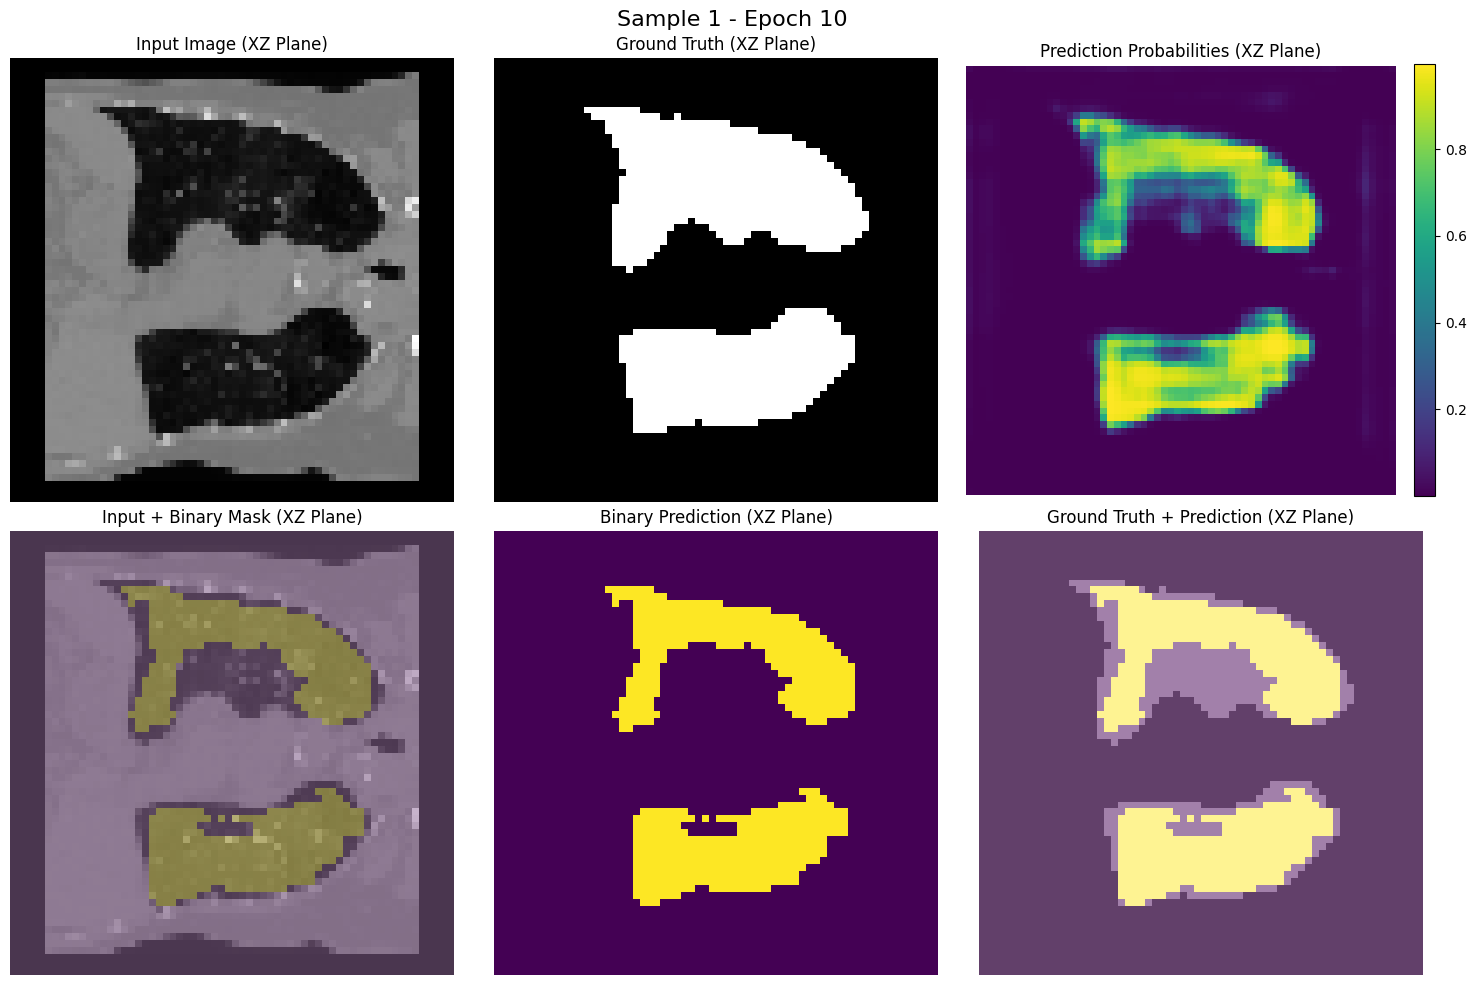

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 557ms/step - dice: 0.9151 - io_u: 0.8435 - loss: 1.1728 - val_dice: 0.8103 - val_io_u: 0.6813 - val_loss: 0.9710 - learning_rate: 0.0010
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - dice: 0.9169 - io_u: 0.8466 - loss: 0.8373
Epoch 11: val_loss improved from 0.97104 to 0.66624, saving model to /kaggle/working/checkpoints/best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 295ms/step - dice: 0.9170 - io_u: 0.8468 - loss: 0.8326 - val_dice: 0.8820 - val_io_u: 0.7889 - val_loss: 0.6662 - learning_rate: 0.0010
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - dice: 0.9157 - io_u: 0.8446 - loss: 0.6045
Epoch 12: val_loss improved from 0.66624 to 0.50314, saving model to /kaggle/working/checkpoints/best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 286ms/step - dice: 0.9159 - io_u: 0.8449 - loss: 0.6013 - val_dice: 0.8672 - val_io_u: 0.7656 - val_loss: 0.5031 - learning_rate: 0.0010
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - dice: 0.9204 - i

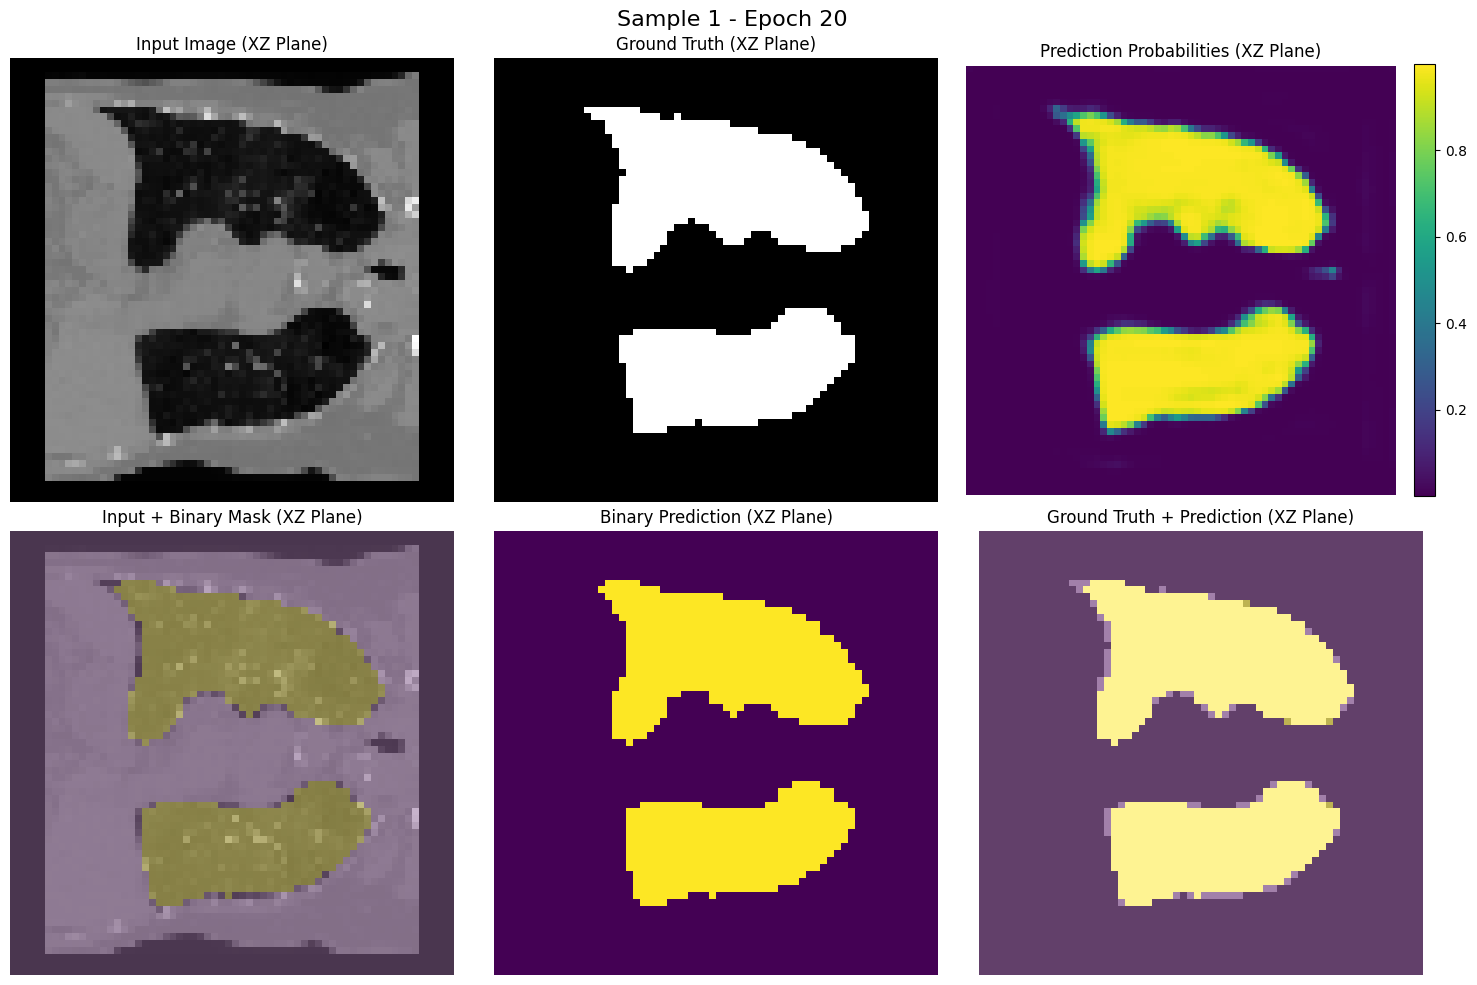

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 568ms/step - dice: 0.9288 - io_u: 0.8671 - loss: 0.1000 - val_dice: 0.8990 - val_io_u: 0.8166 - val_loss: 0.1083 - learning_rate: 0.0010
Epoch 21/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - dice: 0.9241 - io_u: 0.8589 - loss: 0.0930
Epoch 21: val_loss improved from 0.10833 to 0.10094, saving model to /kaggle/working/checkpoints/best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step - dice: 0.9242 - io_u: 0.8591 - loss: 0.0930 - val_dice: 0.9033 - val_io_u: 0.8236 - val_loss: 0.1009 - learning_rate: 0.0010
Epoch 22/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - dice: 0.9285 - io_u: 0.8666 - loss: 0.0865
Epoch 22: val_loss improved from 0.10094 to 0.09971, saving model to /kaggle/working/checkpoints/best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - dice: 0.9285 - io_u: 0.8665 - loss: 0.0864 - val_dice: 0.8938 - val_io_u: 0.8080 - val_loss: 0.0997 - learning_rate: 0.0010
Epoch 23/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - dice: 0.9291 - i

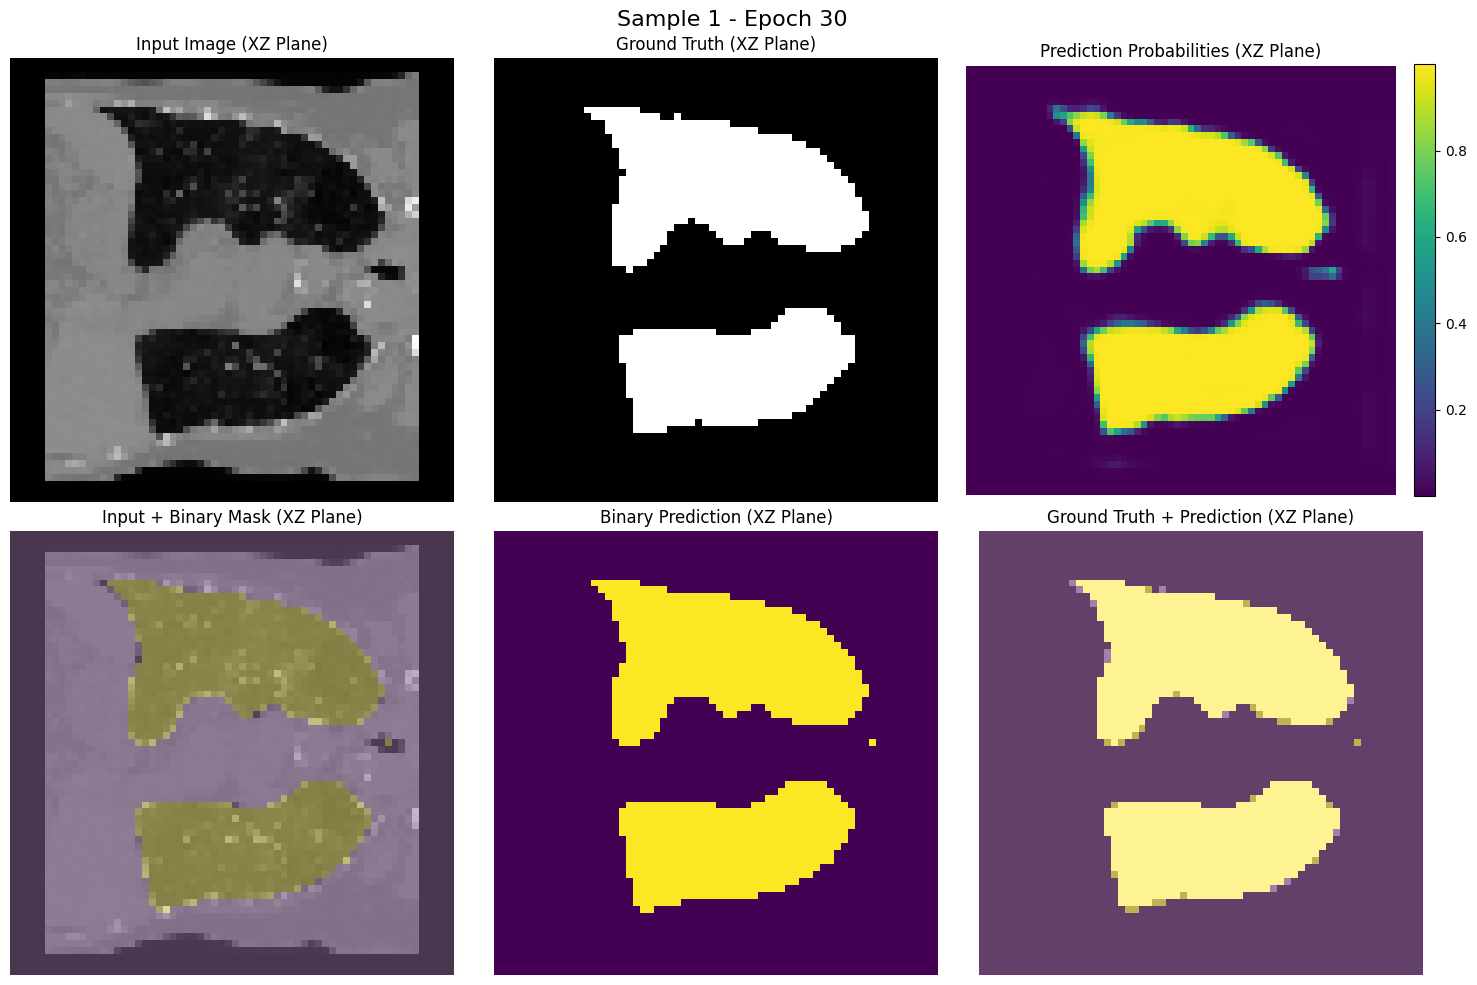

12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 631ms/step - dice: 0.9321 - io_u: 0.8729 - loss: 0.0637 - val_dice: 0.9270 - val_io_u: 0.8639 - val_loss: 0.0630 - learning_rate: 0.0010
Epoch 31/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - dice: 0.9364 - io_u: 0.8804 - loss: 0.0598
Epoch 31: val_loss improved from 0.06295 to 0.06269, saving model to /kaggle/working/checkpoints/best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - dice: 0.9363 - io_u: 0.8803 - loss: 0.0598 - val_dice: 0.9252 - val_io_u: 0.8608 - val_loss: 0.0627 - learning_rate: 0.0010
Epoch 32/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - dice: 0.9318 - io_u: 0.8724 - loss: 0.0602
Epoch 32: val_loss did not improve from 0.06269
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - dice: 0.9320 - io_u: 0.8727 - loss: 0.0601 - val_dice: 0.9219 - val_io_u: 0.8552 - val_loss: 0.0648 - learning_rate: 0.0010
Epoch 33/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - dice: 0.9352 - io_u: 0.8783 - loss: 0.0575
Epoch 33: val_loss improved from 0.0626

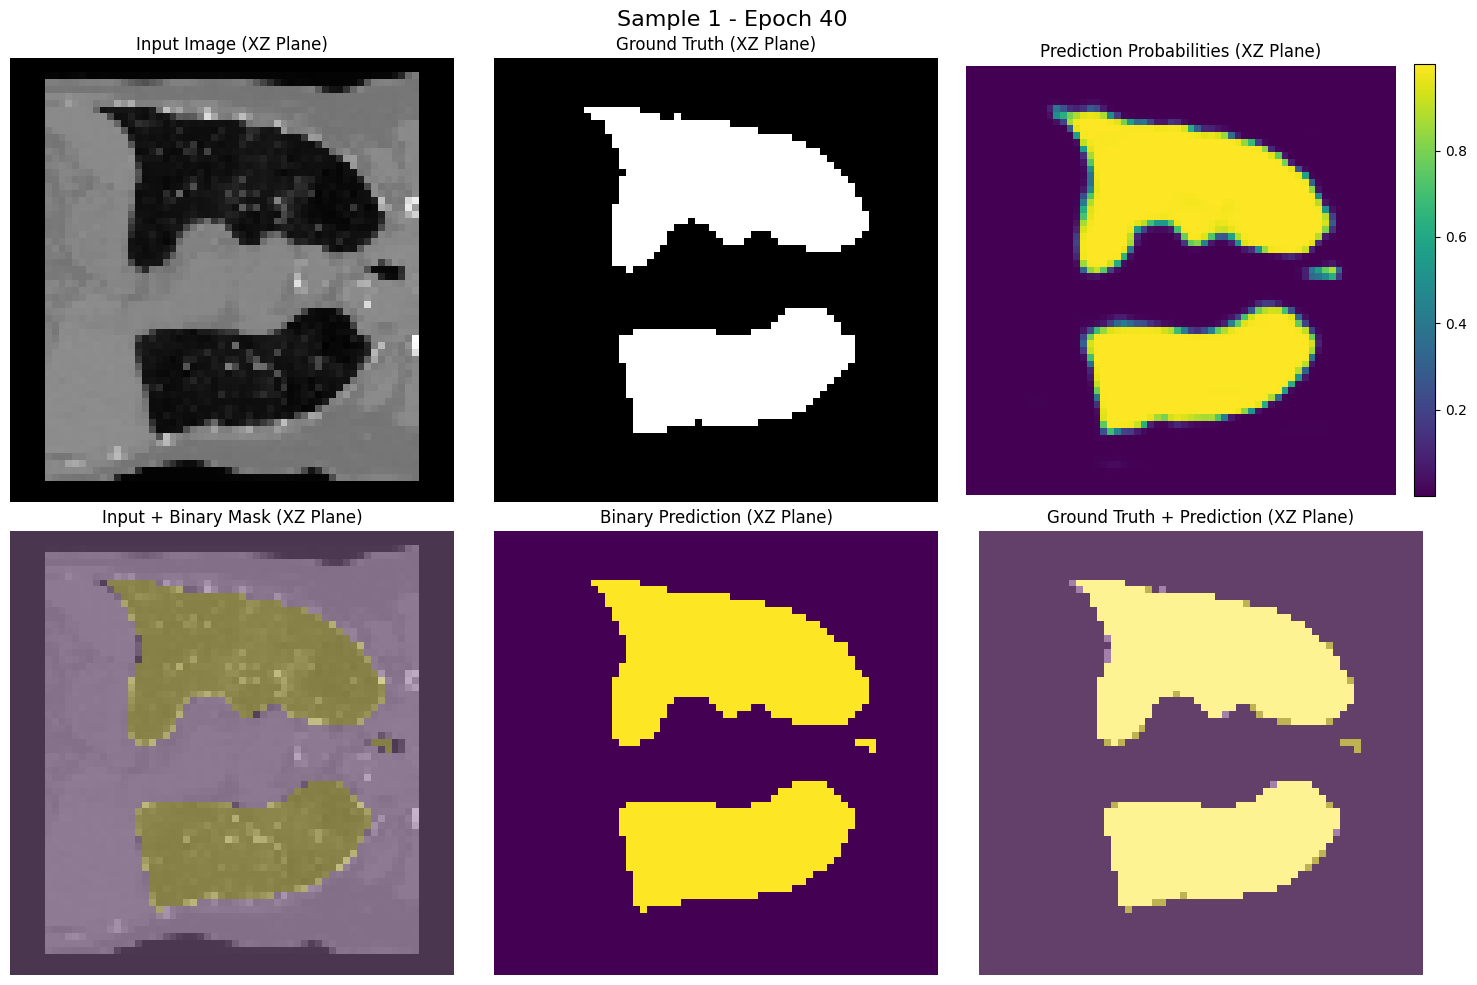

12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 509ms/step - dice: 0.9373 - io_u: 0.8820 - loss: 0.0553 - val_dice: 0.9243 - val_io_u: 0.8592 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 41/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - dice: 0.9399 - io_u: 0.8867 - loss: 0.0541
Epoch 41: val_loss improved from 0.05340 to 0.05253, saving model to /kaggle/working/checkpoints/best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - dice: 0.9399 - io_u: 0.8866 - loss: 0.0541 - val_dice: 0.9380 - val_io_u: 0.8833 - val_loss: 0.0525 - learning_rate: 0.0010
Epoch 42/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - dice: 0.9402 - io_u: 0.8872 - loss: 0.0527
Epoch 42: val_loss did not improve from 0.05253
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 244ms/step - dice: 0.9402 - io_u: 0.8873 - loss: 0.0527 - val_dice: 0.9219 - val_io_u: 0.8551 - val_loss: 0.0614 - learning_rate: 0.0010
Epoch 43/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - dice: 0.9408 - io_u: 0.8882 - loss: 0.0504
Epoch 43: val_loss did not improve from 

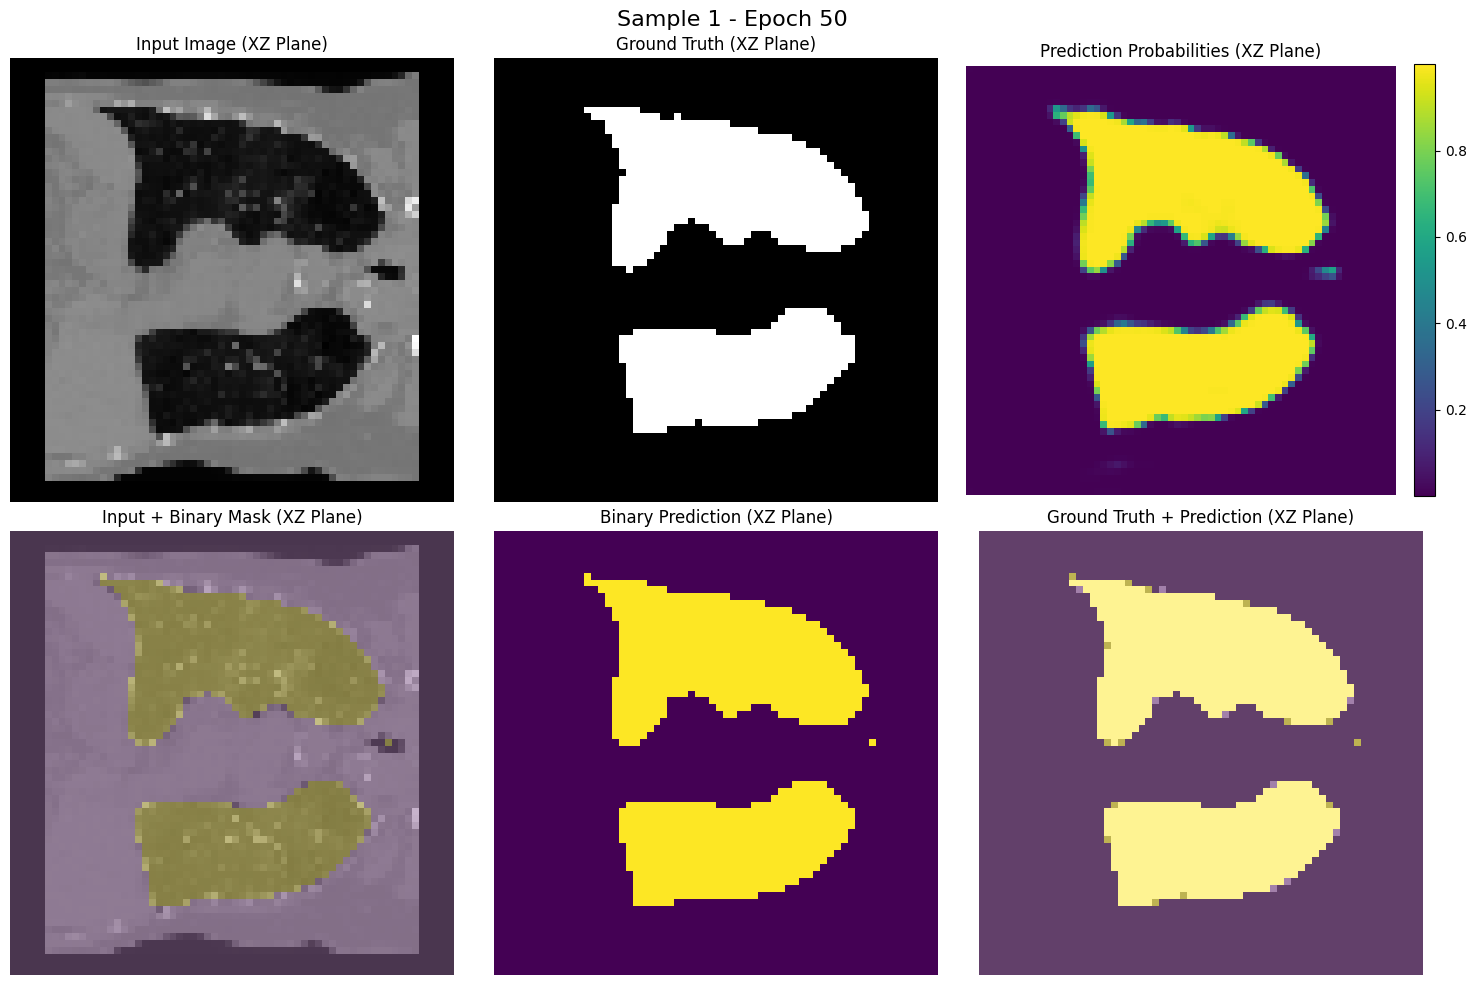

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 546ms/step - dice: 0.9418 - io_u: 0.8900 - loss: 0.0495 - val_dice: 0.9462 - val_io_u: 0.8978 - val_loss: 0.0461 - learning_rate: 0.0010
Epoch 51/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - dice: 0.9416 - io_u: 0.8897 - loss: 0.0504
Epoch 51: val_loss did not improve from 0.04606
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - dice: 0.9416 - io_u: 0.8896 - loss: 0.0504 - val_dice: 0.9442 - val_io_u: 0.8943 - val_loss: 0.0466 - learning_rate: 0.0010
Epoch 52/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - dice: 0.9432 - io_u: 0.8925 - loss: 0.0490
Epoch 52: val_loss did not improve from 0.04606
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - dice: 0.9432 - io_u: 0.8925 - loss: 0.0490 - val_dice: 0.9434 - val_io_u: 0.8928 - val_loss: 0.0471 - learning_rate: 0.0010
Epoch 53/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - dice: 0.9434 - io_u: 0.8930 - loss: 0.0472
Epoch 53: val_loss did not improve from 0.04606
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 254ms/step - dice: 0.9434 -

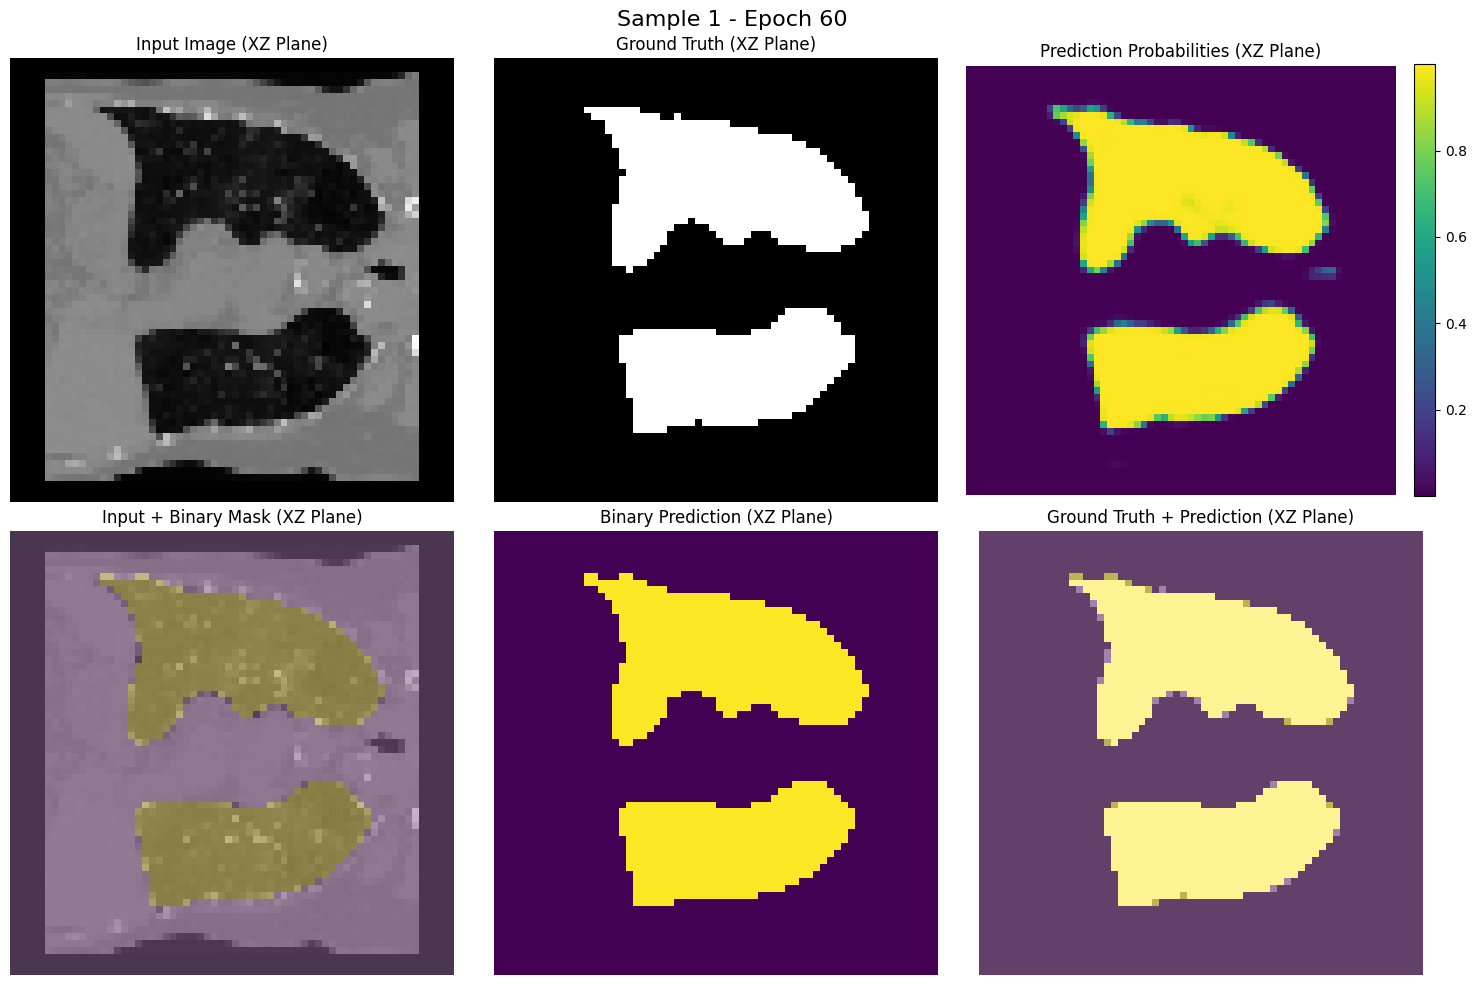

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 530ms/step - dice: 0.9454 - io_u: 0.8965 - loss: 0.0463 - val_dice: 0.9466 - val_io_u: 0.8987 - val_loss: 0.0454 - learning_rate: 0.0010
Epoch 61/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - dice: 0.9438 - io_u: 0.8937 - loss: 0.0472
Epoch 61: val_loss did not improve from 0.04490
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 252ms/step - dice: 0.9439 - io_u: 0.8938 - loss: 0.0472 - val_dice: 0.9407 - val_io_u: 0.8881 - val_loss: 0.0475 - learning_rate: 5.0000e-04
Epoch 62/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - dice: 0.9444 - io_u: 0.8948 - loss: 0.0466
Epoch 62: val_loss improved from 0.04490 to 0.04278, saving model to /kaggle/working/checkpoints/best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step - dice: 0.9444 - io_u: 0.8948 - loss: 0.0467 - val_dice: 0.9481 - val_io_u: 0.9013 - val_loss: 0.0428 - learning_rate: 5.0000e-04
Epoch 63/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - dice: 0.9423 - io_u: 0.8910 - loss: 0.0488
Epoch 63: val_loss did not impr

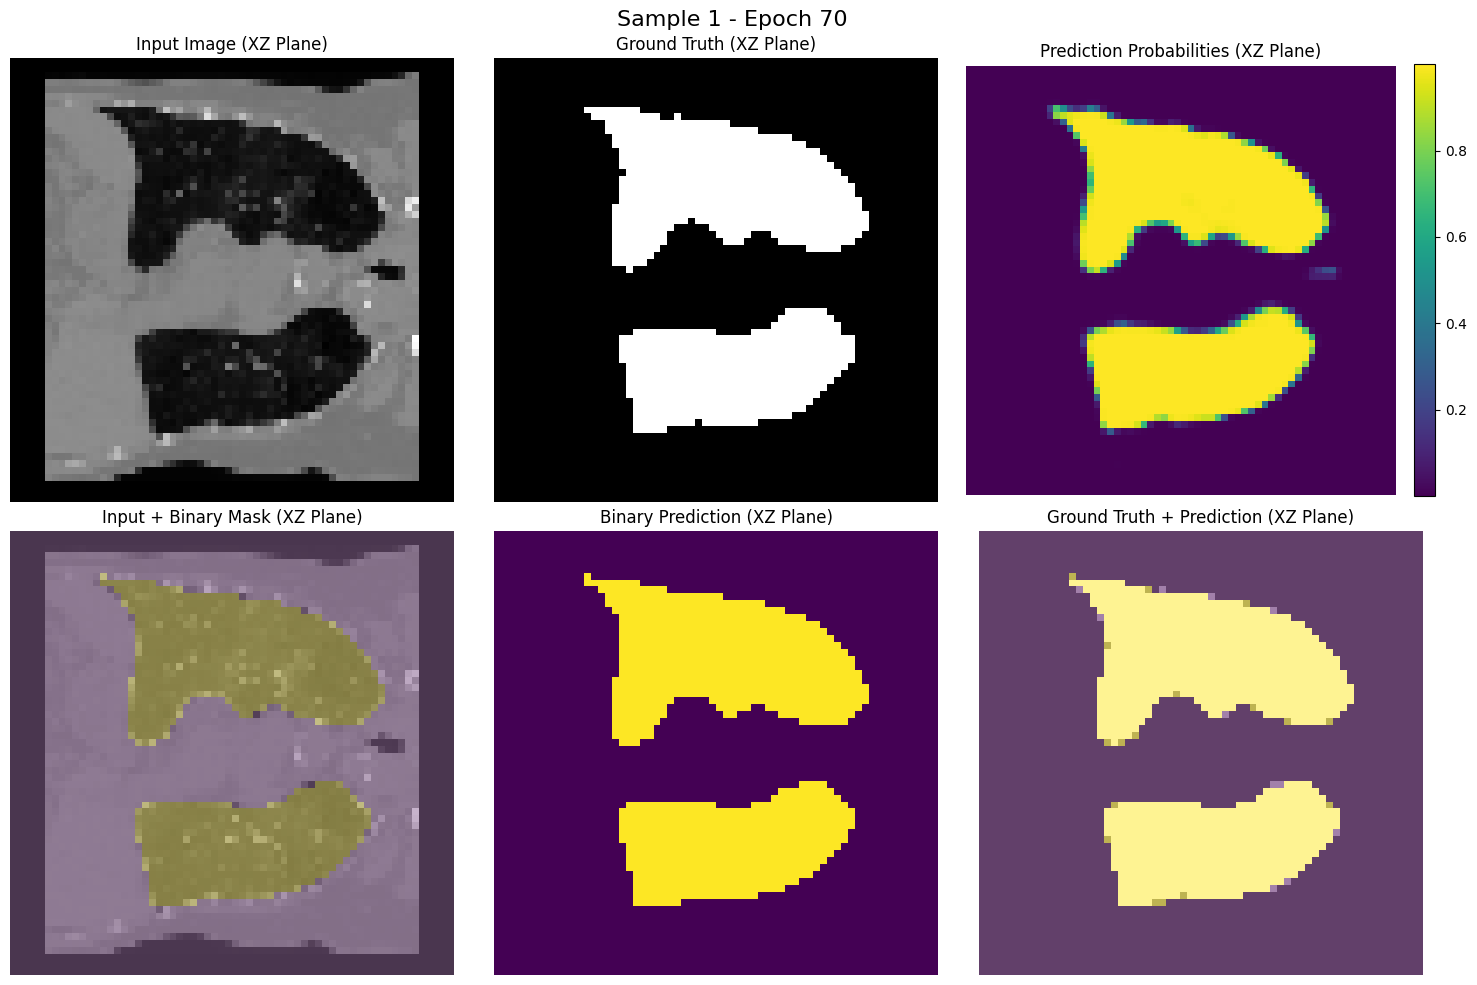

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 532ms/step - dice: 0.9454 - io_u: 0.8964 - loss: 0.0460 - val_dice: 0.9471 - val_io_u: 0.8996 - val_loss: 0.0428 - learning_rate: 5.0000e-04
Epoch 71/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - dice: 0.9480 - io_u: 0.9012 - loss: 0.0434
Epoch 71: val_loss did not improve from 0.04134
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - dice: 0.9479 - io_u: 0.9010 - loss: 0.0434 - val_dice: 0.9469 - val_io_u: 0.8993 - val_loss: 0.0430 - learning_rate: 5.0000e-04
Epoch 72/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - dice: 0.9465 - io_u: 0.8984 - loss: 0.0440
Epoch 72: val_loss did not improve from 0.04134
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - dice: 0.9463 - io_u: 0.8982 - loss: 0.0441 - val_dice: 0.9481 - val_io_u: 0.9013 - val_loss: 0.0423 - learning_rate: 5.0000e-04
Epoch 73/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - dice: 0.9483 - io_u: 0.9017 - loss: 0.0421
Epoch 73: val_loss improved from 0.04134 to 0.04040, saving model to /kaggle/working/checkpoi

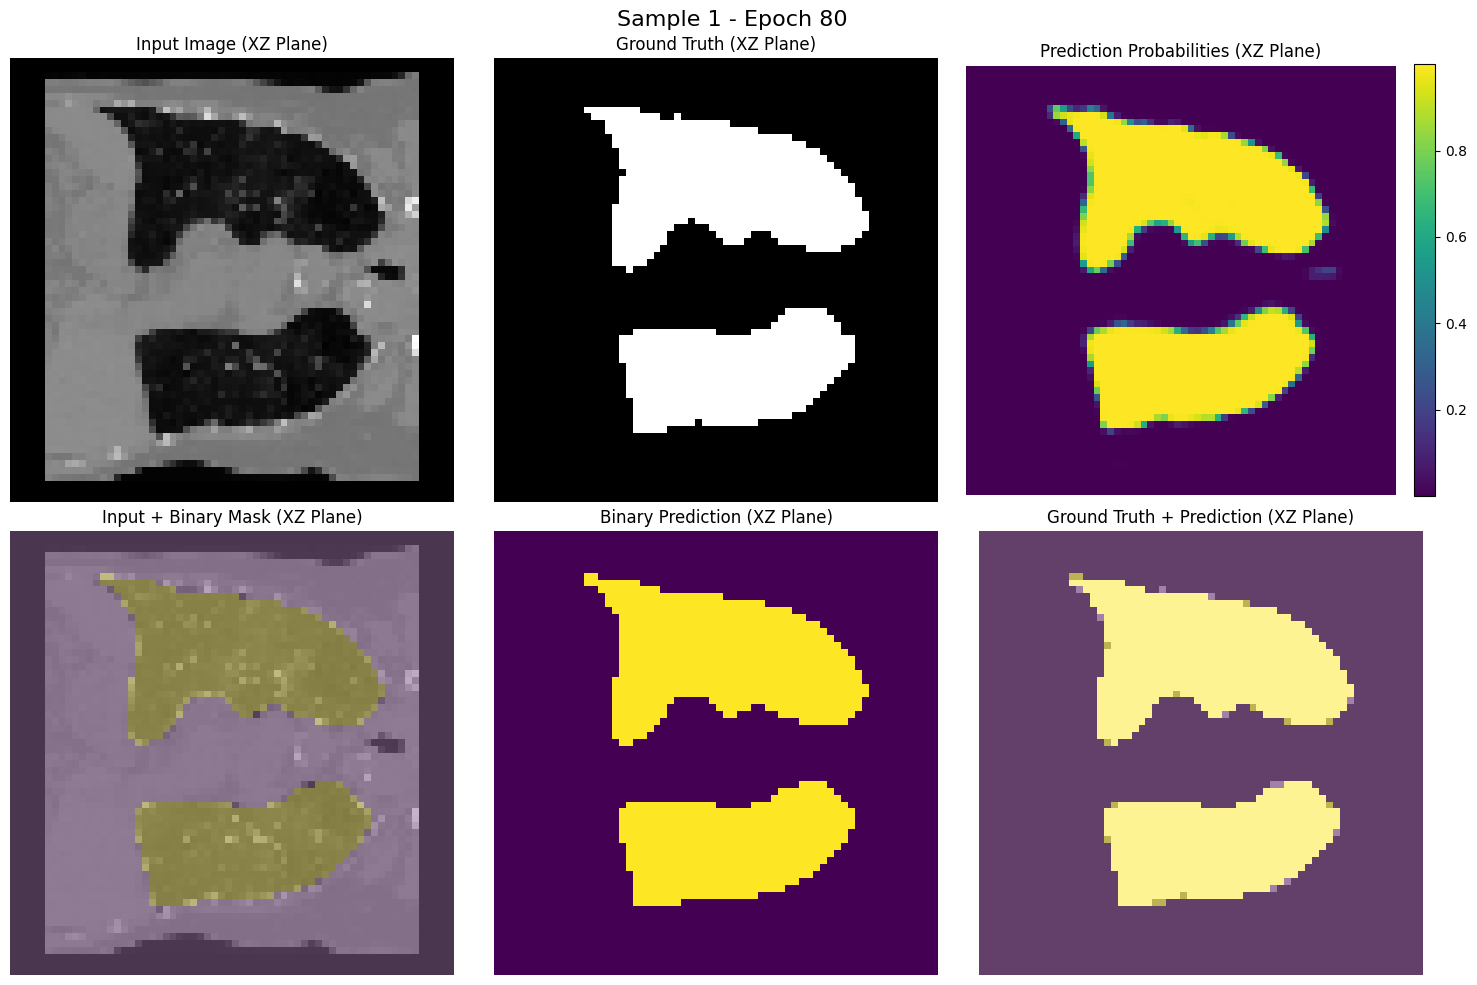

12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 516ms/step - dice: 0.9459 - io_u: 0.8974 - loss: 0.0447 - val_dice: 0.9496 - val_io_u: 0.9040 - val_loss: 0.0413 - learning_rate: 5.0000e-04
Epoch 81/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - dice: 0.9470 - io_u: 0.8994 - loss: 0.0431
Epoch 81: val_loss did not improve from 0.03996

Epoch 81: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - dice: 0.9470 - io_u: 0.8993 - loss: 0.0431 - val_dice: 0.9496 - val_io_u: 0.9040 - val_loss: 0.0418 - learning_rate: 5.0000e-04
Epoch 82/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - dice: 0.9468 - io_u: 0.8990 - loss: 0.0430
Epoch 82: val_loss did not improve from 0.03996
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - dice: 0.9467 - io_u: 0.8989 - loss: 0.0431 - val_dice: 0.9504 - val_io_u: 0.9055 - val_loss: 0.0405 - learning_rate: 2.5000e-04
Epoch 83/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - dice: 0.9486 - io_u: 0.9022 - loss: 0.0425
Epoch 83: val_lo

In [101]:

train_model(unet, sequence, val_data)

In [102]:
def plot_loss(history):
    """
    Plots training and validation loss over epochs.
    
    Args:
        history: Training history object returned by model.fit.
    """
    # Extract loss values
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    dice = history.history['dice']
    val_dice = history.history['val_dice']
    iou = history.history['io_u']
    val_io_u = history.history['val_io_u']
    epochs = range(1, len(train_loss) + 1)

    # Plot the loss values
    plt.figure(figsize=(10, 8))
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Dice
    plt.figure(figsize=(10, 8))
    plt.plot(epochs, dice, label="Training Dice")
    plt.plot(epochs, val_dice, label="Validation Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.title("Dice Score Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot IoU
    plt.figure(figsize=(10, 8))
    plt.plot(epochs, dice, label="Training IoU")
    plt.plot(epochs, val_dice, label="Validation IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.title("IoU Score Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


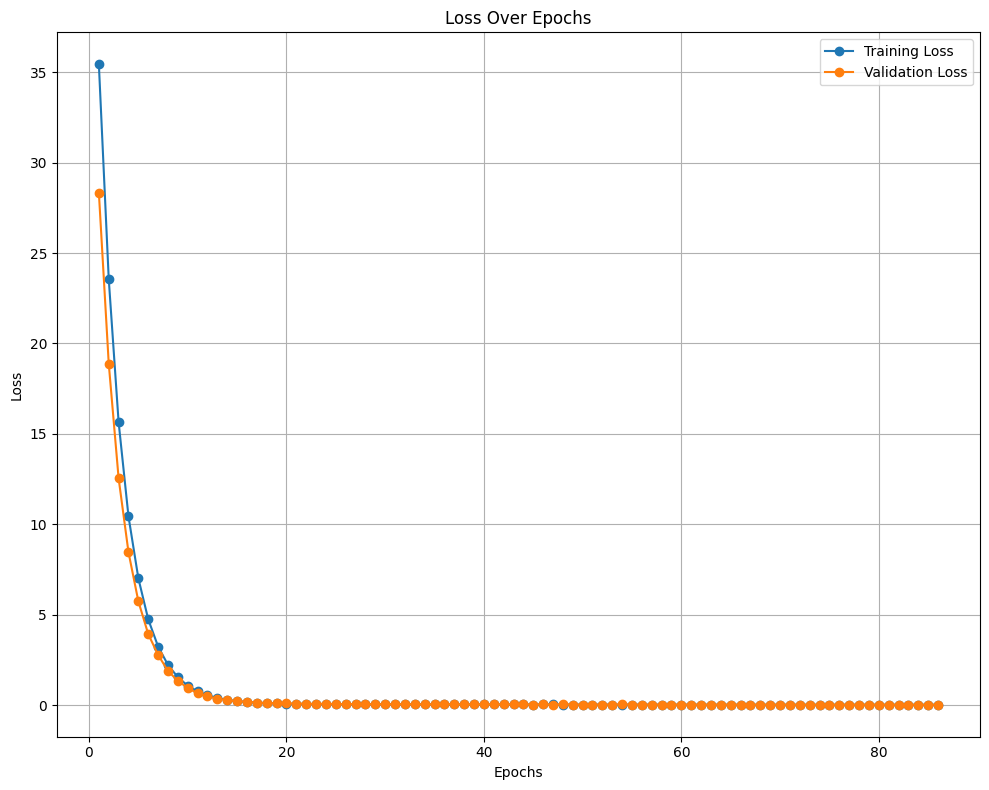

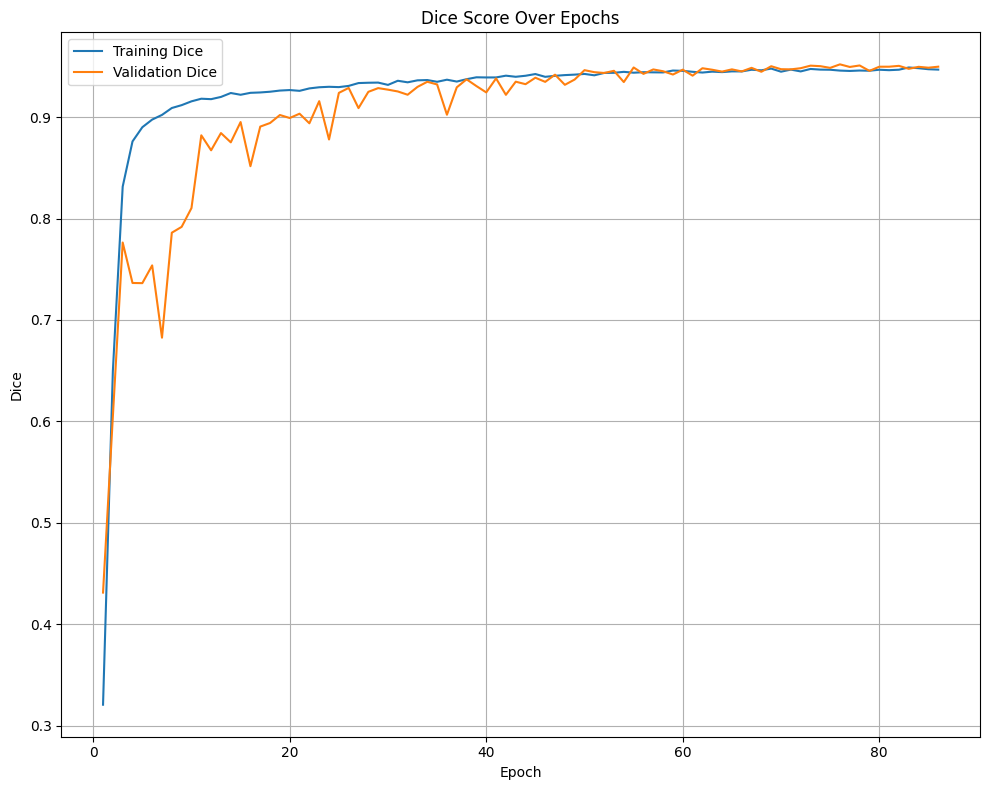

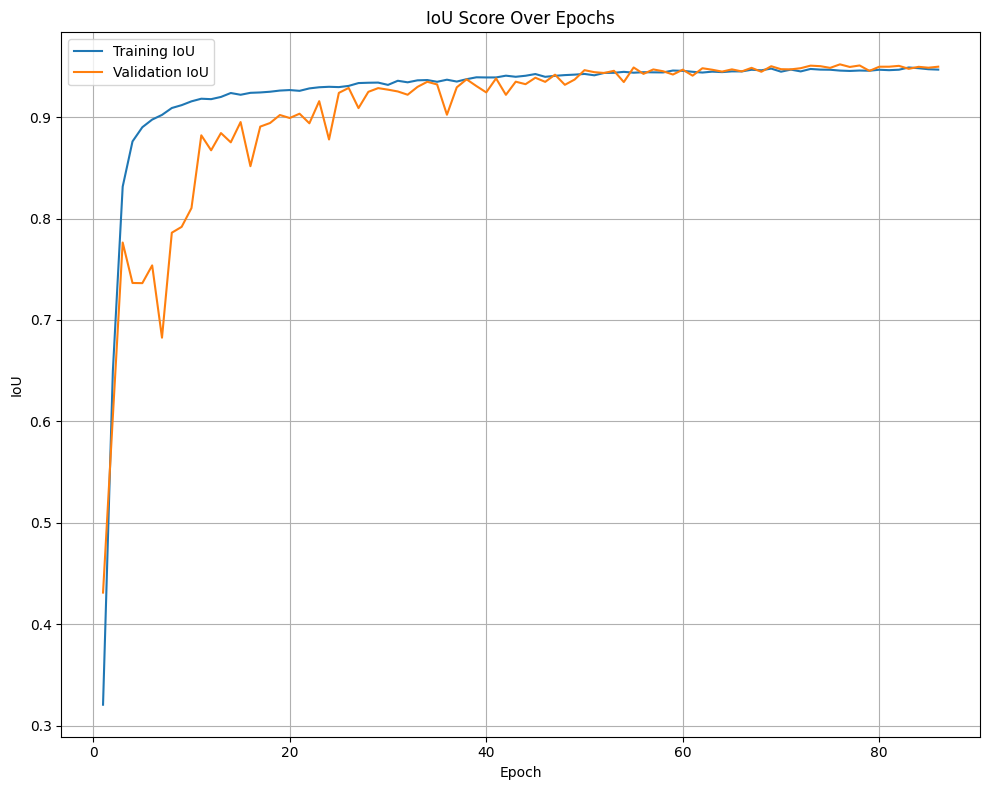

In [103]:
plot_loss(unet.history)

In [109]:
from tensorflow.keras.metrics import IoU

# Define IoU metric with required arguments
iou_metric = IoU(num_classes=2, target_class_ids=[0, 1])
"""# Evaluate on the test data
test_results = best_model.evaluate(test_data, verbose=1)

# Print test results
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Dice: {test_results[1]:.4f}")
print(f"Test IoU: {test_results[2]:.4f}")"""


def test_model_with_visualization(model, test_data, checkpoint_path, num_samples=5):
    """
    Evaluates the model and visualizes predictions alongside ground truth images.

    Parameters:
    - model: The trained model to be tested.
    - test_data: The test dataset (already batched dataset or Sequence).
    - checkpoint_path: Path to the saved model checkpoint (e.g., "best_model.keras").
    - num_samples: Number of samples to visualize (default: 5).

    Returns:
    - results: A dictionary containing loss and metrics for the test dataset.
    """

    # Load the best model from the checkpoint
    if os.path.exists(checkpoint_path):
        model = tf.keras.models.load_model(
            checkpoint_path,
            custom_objects={
                "combined_loss": combined_loss,
                "Dice": Dice,
                "IoU": iou_metric  # Use the IoU metric instance
            }
        )
        print(f"Model loaded from {checkpoint_path}")
    else:
        raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")

    # Evaluate the model on the test dataset
    results = model.evaluate(test_data, verbose=1)

    # Print test results
    print("\nTest Results:")
    for metric_name, value in zip(model.metrics_names, results):
        print(f"{metric_name}: {value:.4f}")

    # Visualization of predictions in the XZ plane
    print("\nVisualizing predictions...")
    for batch_images, batch_labels in test_data.take(1):  # Take one batch from the test dataset
        predictions = model.predict(batch_images)  # Get model predictions
        binary_predictions = (predictions > 0.5).astype(np.uint8)  # Binarize predictions (assuming segmentation task)

        # Visualize the first num_samples examples
        for i in range(min(num_samples, len(batch_images))):
            data = batch_images[i].numpy()
            data_m = batch_labels[i].numpy()
            pred_probs = predictions[i]  # Prediction probabilities
            binary_pred_m = binary_predictions[i]  # Binary predictions

            fig, ax = plt.subplots(2, 3, figsize=(15, 10), tight_layout=True)
            fig.suptitle(f"Sample {i + 1} - XZ Plane", fontsize=16)

            y_dim = data.shape[1]

            # Input Image on XZ plane
            ax[0, 0].set_title("Input Image (XZ Plane)")
            img1 = ax[0, 0].imshow(data[:, y_dim // 2, :], cmap="gray")
            ax[0, 0].axis("off")

            # Ground Truth on XZ plane
            ax[0, 1].set_title("Ground Truth (XZ Plane)")
            img2 = ax[0, 1].imshow(data_m[:, y_dim // 2, :], cmap="gray")
            ax[0, 1].axis("off")

            # Prediction Probabilities on XZ plane
            ax[0, 2].set_title("Prediction Probabilities (XZ Plane)")
            img3 = ax[0, 2].imshow(pred_probs[:, y_dim // 2, :])
            ax[0, 2].axis("off")
            fig.colorbar(img3, ax=ax[0, 2], fraction=0.046, pad=0.04)

            # Binary Mask - Input Image Overlay
            ax[1, 0].set_title("Input + Binary Mask (XZ Plane)")
            ax[1, 0].imshow(data[:, y_dim // 2, :], cmap="gray", alpha=0.7)
            ax[1, 0].imshow(binary_pred_m[:, y_dim // 2, :], alpha=0.3)
            ax[1, 0].axis("off")

            # Binary Prediction Mask on XZ plane
            ax[1, 1].set_title("Binary Prediction (XZ Plane)")
            ax[1, 1].imshow(binary_pred_m[:, y_dim // 2, :])
            ax[1, 1].axis("off")

            # Ground Truth vs Prediction Overlay
            ax[1, 2].set_title("Ground Truth + Prediction (XZ Plane)")
            ax[1, 2].imshow(data_m[:, y_dim // 2, :], cmap="gray", alpha=0.5)
            ax[1, 2].imshow(binary_pred_m[:, y_dim // 2, :], alpha=0.5)
            ax[1, 2].axis("off")

            plt.show()

        break  # Visualize only the first batch

    return dict(zip(model.metrics_names, results))




Model loaded from /kaggle/working/checkpoints/best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - dice: 0.9428 - io_u: 0.4540 - loss: 0.0443

Test Results:
loss: 0.0432
compile_metrics: 0.9447

Visualizing predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


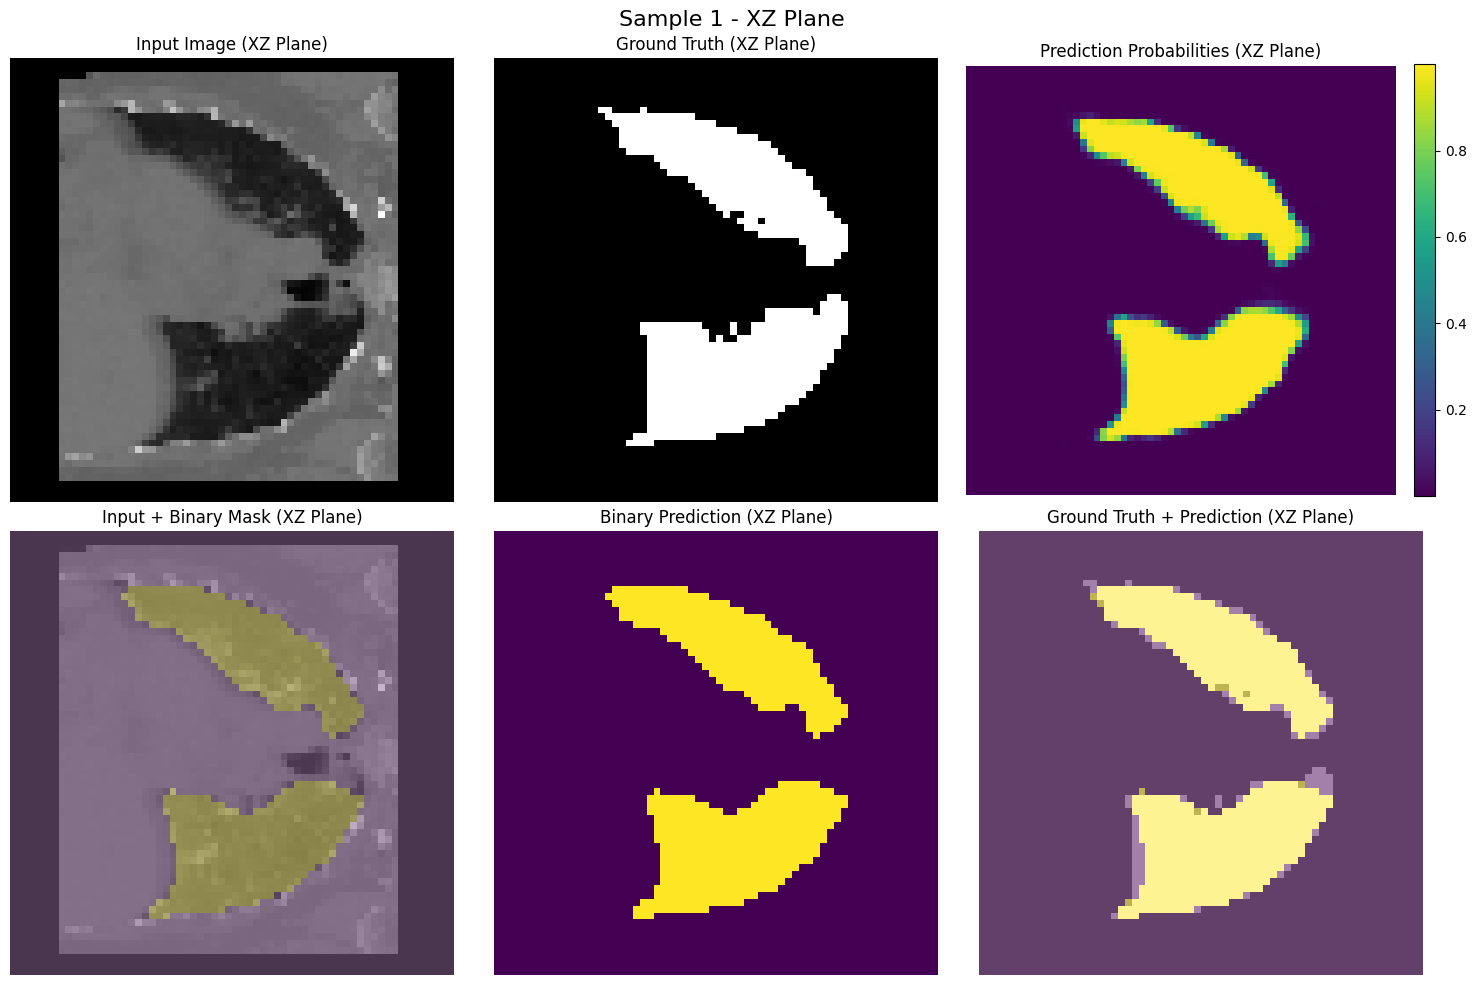

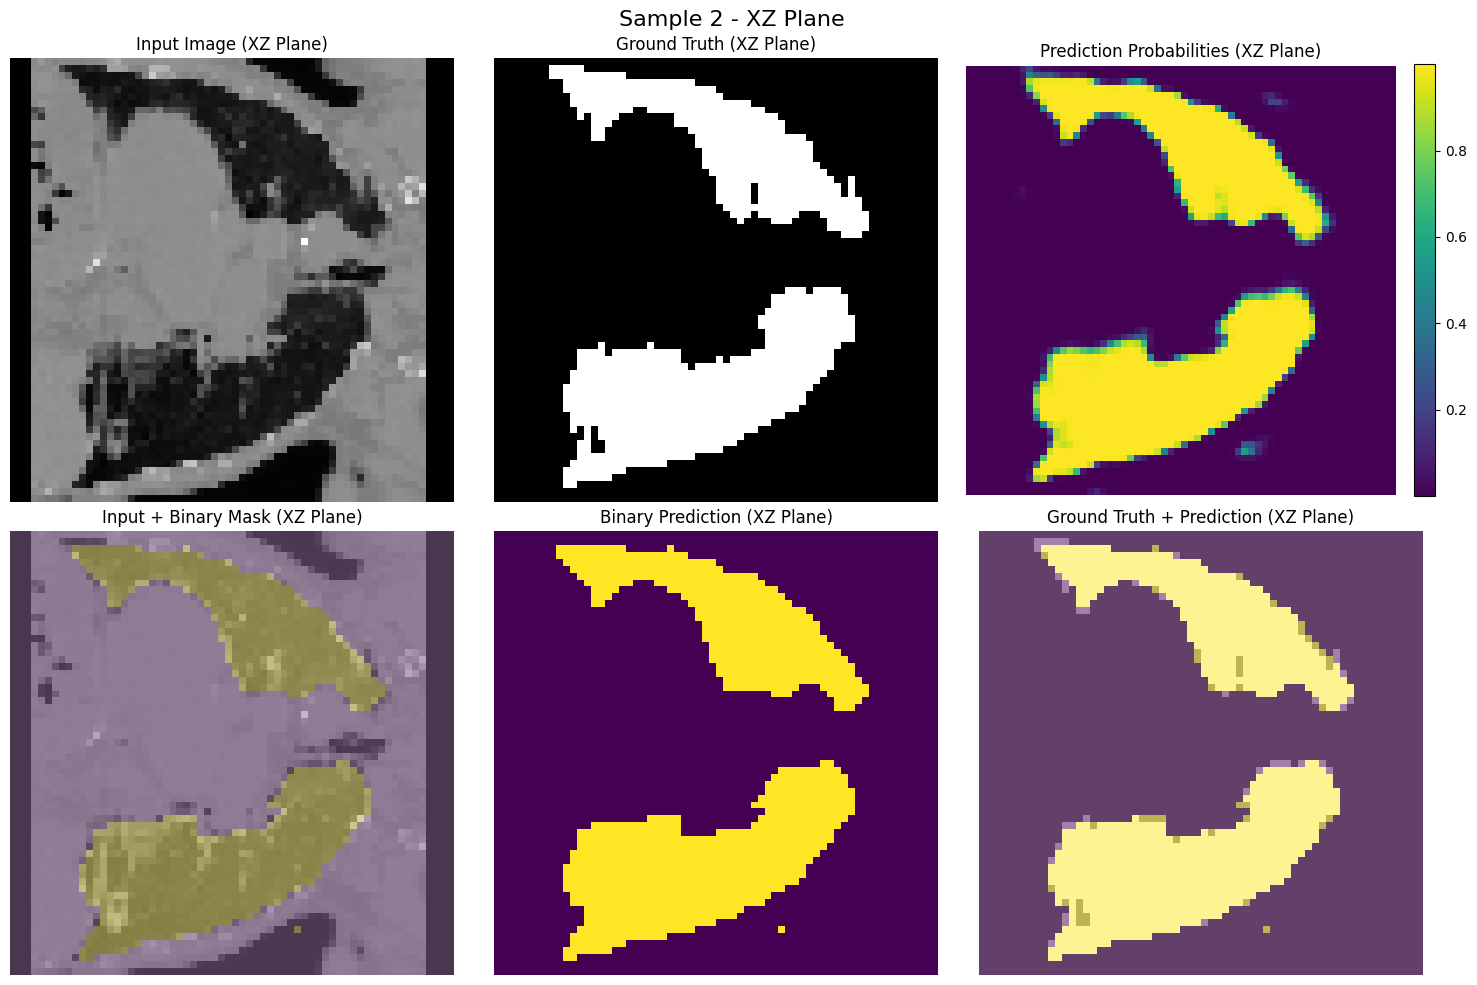

In [107]:
# Test and visualize predictions
test_results = test_model_with_visualization(
    model=unet,
    test_data=test_data,
    checkpoint_path="/kaggle/working/checkpoints/best_model.keras",
    num_samples=5
)

## References

[1] Kamnitsas, Konstantinos, et al. "Ensembles of multiple models and architectures for robust brain tumour segmentation." International MICCAI brainlesion workshop. Springer, Cham, 2017.

[2] [Lung CT Segmentation Challenge 2017](https://wiki.cancerimagingarchive.net/display/Public/Lung+CT+Segmentation+Challenge+2017)